In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from typing import Tuple
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as albu
import utils.segmentation_models.segmentation_models_pytorch.utils as smp_utils

We will be only catering to AOI : Rio for now.

ref : https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#writing-a-custom-dataset-for-pennfudan, https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [2]:
SATELLITE_IMAGES_PATH = 'data/AOI_1_rio/imgs'
MASKS_PATH = 'data/AOI_1_rio/masks'
IMG_SIZE = (438, 406) # width, height

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
# A `Dataset` should override `__len__` and `__getitem__`
class BuildingFootprintDataset(Dataset):
    def __init__(self, satellite_imgs_path:str, masks_path:str, augmentation=None, preprocessing=None) -> None:
        super().__init__()
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        assert os.path.isdir(masks_path)
        assert os.path.isdir(satellite_imgs_path)
        self.satellite_imgs_path = satellite_imgs_path
        self.masks_path = masks_path 
        self.images = sorted(os.listdir(satellite_imgs_path), key=lambda x: int(x.split('.')[0]))
        self.image_masks = sorted(os.listdir(masks_path), key=lambda x: int(x.split('.')[0]))
    def __len__(self):
        return len(self.image_masks)
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.satellite_imgs_path, self.images[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_path, self.image_masks[index]),cv2.IMREAD_GRAYSCALE)
        # split mask into many masks, one per instance
        # each instance has a different color, as defined in the mask creation process from the raster files
        obj_ids = np.sort(np.unique(mask))[1:]
        masks = [(mask == v) for v in obj_ids]
        masks = np.stack(masks, axis=-1).astype('float')
        # mask_np = np.array(mask)
        # print(len(obj_ids))
        # masks = mask_np==obj_ids[:,None,None] 
        # masks = np.stack([m for m in masks],axis=-1)
        
        # apply augmentations
        if self.augmentation:
            # print(masks)
            sample = self.augmentation(image=image, masks_arr=masks, mask=mask)
            image, masks, mask = sample['image'], sample['masks_arr'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, masks_arr=masks,mask=mask)
            image, masks, mask = sample['image'], sample['masks_arr'], sample['mask']
            
        return image, mask, masks
        
    

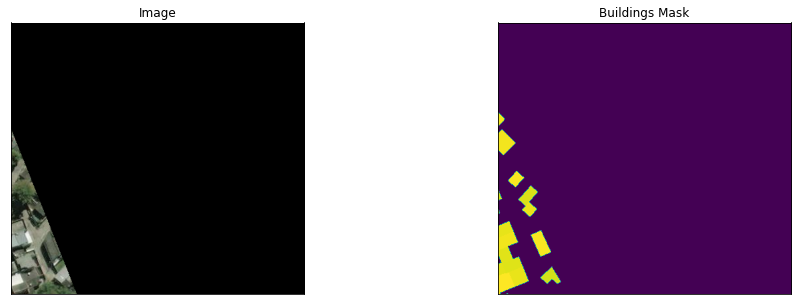

In [5]:
dataset = BuildingFootprintDataset(SATELLITE_IMAGES_PATH,MASKS_PATH)
img, mask, masks = dataset[6939]
visualize(
    image=img,
    buildings_mask=mask
)

Transformations

In [8]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(IMG_SIZE[1],IMG_SIZE[0]),
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        albu.Resize(IMG_SIZE[1], IMG_SIZE[0])
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        # albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

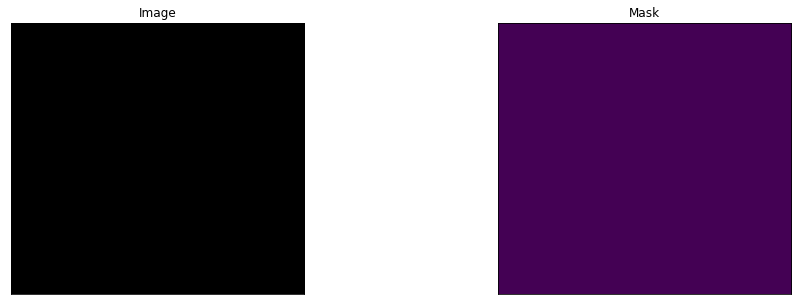

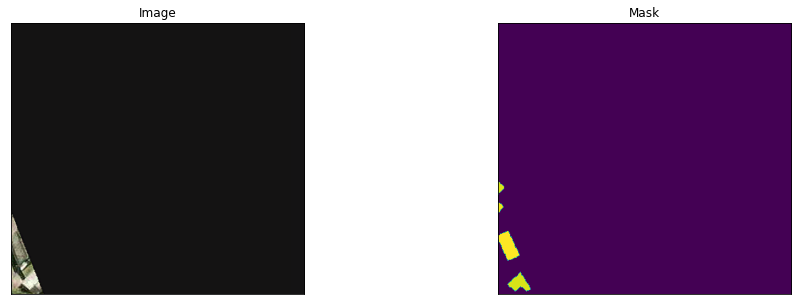

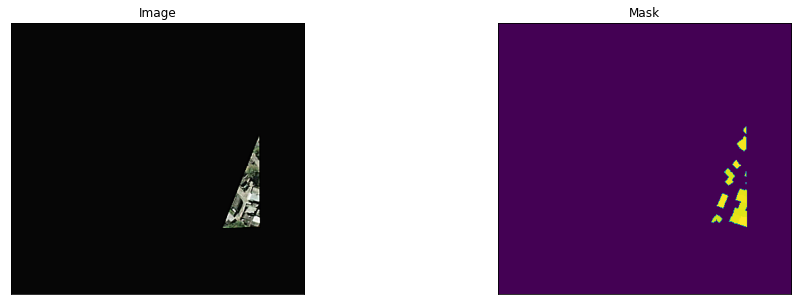

In [9]:
#### Visualize resulted augmented images and masks

augmented_dataset = BuildingFootprintDataset(
    SATELLITE_IMAGES_PATH, 
    MASKS_PATH, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    # image, mask, masks = augmented_dataset[1]
    image, mask, masks = augmented_dataset[6939]
    visualize(image=image, mask=mask)

In [10]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
# DEVICE = 'cuda'
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

In [11]:
train_dataset = BuildingFootprintDataset(
    SATELLITE_IMAGES_PATH, 
    MASKS_PATH, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)

## losses, metrics and optimizer
loss = smp_utils.losses.DiceLoss()
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [186]:

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [171]:
torch.cuda.is_available()

/home/rohan/anaconda3/envs/thinkocean/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [187]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    # valid_logs = valid_epoch.run(valid_loader)
    
    # # do something (save model, change lr, etc.)
    # if max_score < valid_logs['iou_score']:
    #     max_score = valid_logs['iou_score']
    #     torch.save(model, './best_model.pth')
    #     print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/868 [00:00<?, ?it/s]


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/rohan/anaconda3/envs/thinkocean/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/rohan/anaconda3/envs/thinkocean/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rohan/anaconda3/envs/thinkocean/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_514686/87703855.py", line 37, in __getitem__
    sample = self.preprocessing(image=image, masks_arr=masks,mask=mask)
  File "/home/rohan/anaconda3/envs/thinkocean/lib/python3.8/site-packages/albumentations/core/composition.py", line 205, in __call__
    data = t(**data)
  File "/home/rohan/anaconda3/envs/thinkocean/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 118, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/home/rohan/anaconda3/envs/thinkocean/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 131, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/home/rohan/anaconda3/envs/thinkocean/lib/python3.8/site-packages/albumentations/augmentations/transforms.py", line 1652, in apply_to_mask
    return fn(mask, **params)
  File "/tmp/ipykernel_514686/3054382397.py", line 49, in to_tensor
    return x.transpose(2, 0, 1).astype('float32')
ValueError: axes don't match array
